# Question Answering with RNNs

There are many structured prediction tasks in machine learning, and many of them involve sequences - particularly sequences of text - in some form. Some examples include sentiment analysis (text to single class), image captioning (single image to text) and machine translation (text to text). Recurrent neural networks (RNNs) are a good fit for such problems, particularly when the sequences involved have an explicit or implicit ordering to the items; conversely, one might find other architectures more suitable if the input is a set. RNNs not only take in and output a single input and output at a time, but also have a hidden state vector which can be used to integrate information over time. They can have more complex units, such as long short-term memory (LSTM) units, that alleviate problems such as vanishing gradients, and be combined with other modules to enable bidirectional reading or attention or memory mechanisms.

We'll focus on text-based question answering, using RNNs to read a story, a query, and predict the answer. This can, broadly speaking, encapsulate several natural language processing (NLP) tasks.

## Data

We'll use the first task from the 20 tasks of the bAbI dataset. This procedurally generated dataset was designed to test text understanding and reasoning, and includes tasks such as answering yes/no questions, counting items, performing coreference resolution, and even basic deduction. In each task there is a story to read, a question, and the answer, with 1000 examples for training and 1000 for testing per task. The first task is based on answering a question with a single supporting fact - we'll set up datasets to iterate over and show an example below. By the standards of the dataset, we'll be looking at a *weakly supervised* setting, as opposed to the *strongly supervised* setting where the indices of the supporting facts (out of all of the facts) are also provided during training.

We'll use `torchtext`, which provides the dataset in a more convenient form. `torchtext` provides several NLP functions, such as tokenisation, as well as helpers for dealing with training on text data. There tends to be a lot of data processing for dealing with text, so it's worth consulting the documentation and other material for how to make use of the package. Here we'll get training and test datasets, along with metadata about the text (such as the vocabulary size).

In [1]:
from collections import namedtuple
import os
from matplotlib import pyplot as plt
from matplotlib import ticker
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchtext import datasets
from IPython.display import clear_output, display
%matplotlib inline

In [12]:
def print_example(example):
    story, query, answer = '\n'.join(' '.join(s) for s in example.story), ' '.join(example.query), ' '.join(example.answer)
    print('Story:\n%s\n-------------------------------------------------\nQuery: %s?\nAnswer: %s' % (story, query, answer))

data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'babi')
train_data, _, test_data = datasets.BABI20.iters(task=1, batch_size=32, root=data_path)
STORY, QUERY, ANSWER = [train_data.dataset.fields[f] for f in ['story', 'query', 'answer']]
print_example(train_data.dataset[2])

Story:
Mary moved to the bathroom
John went to the hallway
Daniel went back to the hallway
Sandra moved to the garden
John moved to the office
Sandra journeyed to the bathroom
-------------------------------------------------
Query: Where is Daniel?
Answer: hallway


## Model

We'll use a combination of models to deal with the different inputs and produce an output. As the words are symbols, these are first passed through an embedding layer to map each symbol into a (learnable) real-valued vector. For the story, we'll use a bidirectional LSTM, as it will be able to better preserve information across larger sequences (that are provided at once - only unidirectional RNNs can be used for online sequences). For the question, we'll use a unidirectional LSTM, and use the final output to "attend" to the sentence states of the story RNN (through a multiplication operation). Finally, this will be passed to a fully-connected network to predict the output (the answers are single words here, so there is no need for an RNN).

In [8]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, zeros_idx, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=zeros_idx)
        self.rnn = nn.LSTM(hidden_size, hidden_size, bidirectional=bidirectional)

    def forward(self, x, h=None):
        x = self.embedding(x)
        if x.dim() == 4:  # Sum embeddings over a sentence in the story encoder
            x = x.sum(2)
        x, _ = self.rnn(x, h)
        return x

class QANetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.s_encoder = Encoder(len(STORY.vocab), hidden_size // 2, zeros_idx=STORY.vocab.stoi['pad'],
                                 bidirectional=True)
        self.q_encoder = Encoder(len(QUERY.vocab), hidden_size, zeros_idx=STORY.vocab.stoi['pad'])
        self.a_generator = nn.Sequential(nn.Linear(hidden_size, hidden_size),
                                         nn.Dropout(0.8),
                                         nn.ReLU(),
                                         nn.Linear(hidden_size, len(ANSWER.vocab)))

    def forward(self, x, h=None):
        s = self.s_encoder(x.story)  # All hidden states
        q = self.q_encoder(x.query)[:, -1]  # Final hidden state
        attention = F.softmax(torch.einsum('bsh,bh->bs', [s, q]), dim=1).unsqueeze(2)  # Multiplicative attention mask
        a = torch.sum(attention * s, 1)
        a = self.a_generator(a)
        return a, attention

## Training and Testing

We'll train the network for a few epochs and plot the training and test losses. We can also visualise the attention of the network over the story, showing which parts it thinks are relevant for answering the question at hand.

'Final test accuracy: 85.60%'

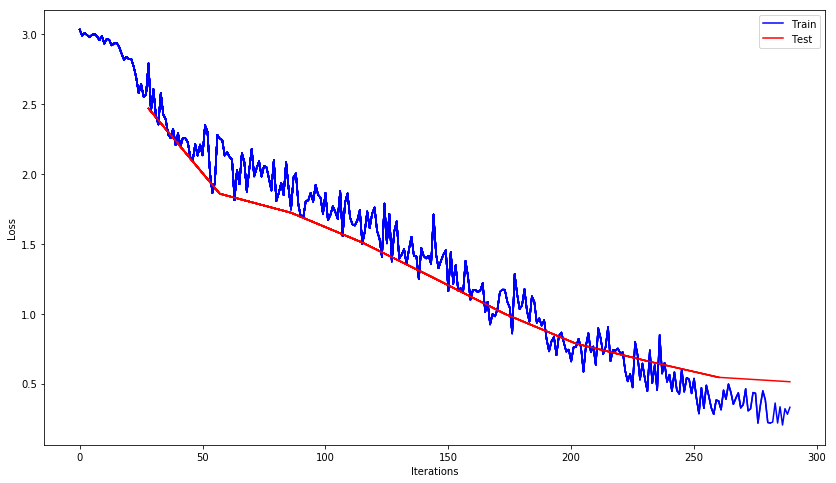

In [13]:
hidden_size = 128
model = QANetwork(hidden_size)
optimiser = optim.Adam(model.parameters(), lr=0.0005)
train_losses, test_losses, test_acc = [], [], 0
epochs, iters_per_epoch = 10, len(train_data)

plt.figure(figsize=(14, 8))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plotted_legend = False


def plot():
    global plotted_legend
    plt.plot(range(len(train_losses)), train_losses, 'b-', label='Train')
    plt.plot([(i + 1) * iters_per_epoch - 1 for i in range(len(test_losses))], test_losses, 'r-', label='Test')
    clear_output(wait=True)
    display(plt.gcf())
    if not plotted_legend:
        plt.legend(loc='upper right')
        plotted_legend = True


def train():
    model.train()
    for i, x in enumerate(train_data):
        optimiser.zero_grad()
        y_hat, _ = model(x)
        loss = F.cross_entropy(y_hat, x.answer.squeeze(1))
        loss.backward()
        train_losses.append(loss.item())
        optimiser.step()
        if i % 10 == 0:
            plot()


def test():
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x in test_data:
            y_hat, _ = model(x)
            test_loss += F.cross_entropy(y_hat, x.answer.squeeze(1), reduction='sum').item()
            pred = y_hat.argmax(1, keepdim=True)
            correct += pred.eq(x.answer).sum().item()

    test_losses.append(test_loss / len(test_data.dataset))
    return correct / len(test_data.dataset)


for _ in range(epochs):
    train()
    test_acc = test()
plot()
clear_output(wait=True)
display('Final test accuracy: %.2f%%' % (test_acc * 100))

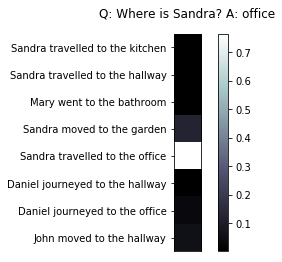

In [14]:
# Create example manually (dataset is re-sorted by length)
example_id = 8
example = test_data.dataset[example_id]
X = namedtuple('X', ['story', 'query'])
x = X(STORY.process([example.story]), QUERY.process([example.query]))

model.eval()
with torch.no_grad():
    y_hat, attention = model(x)

# Plot attention heatmap
fig, ax = plt.subplots()
cax = ax.matshow(attention[0, :len(example.story)].numpy(), cmap='bone')
story = [' '.join(s) for s in example.story]
ax.set_title('Q: ' + ' '.join(example.query) + '? A: ' + example.answer[0])
ax.set_yticks(torch.arange(len(story)))
ax.set_yticklabels(story)
ax.xaxis.set_major_locator(ticker.NullLocator())
fig.colorbar(cax)
display(plt.gcf())
clear_output(wait=True)